In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set display options for Pandas tables so that results are legible.
pd.options.display.max_rows = 2500
pd.options.display.float_format = '{:.5f}'.format

In [122]:
# Define project-wide functions


def scatter_plotter(data,x,y,labels:tuple,title:str): # Manually written
   """
   Plot a scatterplot
   """
   fig = sns.scatterplot(x=x,y=y,hue=data["OCI-R_quartile"])
   fig.grid()
   fig.set_xlim(0,)
   fig.set_ylim(0,)
   fig.set(xlabel=labels[0], ylabel=labels[1], title=title)
             

def scatter_plotter_with_regline(x,y,labels:tuple,title:str,pearson): # Manually written
   """
   Plot a scatterplot with a regression line
   """
   fig = sns.regplot(x=x,y=y, line_kws={"color": "red"})
   fig.grid()
   fig.set_xlim(0,)
   fig.set_ylim(0,)
   fig.set(xlabel=labels[0],
           ylabel=labels[1],
           title=title)
   plt.text(5, 65, 'r = ' + str(round(pearson, 2)))

def plot_confusion_matrix(y_true, y_pred, title): # ChatGPT assisted
    """Plot a confusion matrix."""
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def display_shap_values_bars(model, X_train, model_name): # ChatGPT assisted
    """Compute and plot SHAP values for the model."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)
    print(f"SHAP values for {model_name}")
    print("="*60)

def display_shap_values_point(model, X_train, model_name): # ChatGPT assisted
    """Compute and plot SHAP values for the model."""
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=features)
    print(f"SHAP values for {model_name}")
    print("="*60)

In [78]:
# Load and preprocess data - option 1 (only predictors are individual SPISI item scores)
data = pd.read_excel('Combined_data.xlsx',sheet_name="noDASS")
# print(data.head())

data['OCI-R_quartile'] = pd.qcut(data['OCI-R_sum'].rank(method="first"), 4, labels=[1, 2, 3, 4]) # Used pandas 'rank' method to make quartiles actually equally sized. This means that participants with OCI-R scores of 21 were randomly assigned to quratiles 1 or 2; scores of 28 to Q2 or Q3; and scores of 38 to Q3 or Q4. 

# Remove middle participants; leave only top and bottom quartiles

data_extremes = data[(data["OCI-R_quartile"]==1) | (data["OCI-R_quartile"]==4)]

# data_extremes[["AggregatedID","OCI-R_quartile"]] # Check to see that we've got the right things
features = [col for col in data_extremes.columns if (('SPISI' in col) and ("SPISI_sum" not in col))] # features do not include anything but the scores on SPISI questions
X = data_extremes[features]
y = data_extremes['OCI-R_quartile']

In [40]:
# Test to see table is correct, quartile sizes are correct and the exact bin cutoffs for each quartile (meaning which scores are edge scores that are randomly assigned to adjacent quartiles.)

test_matrix = X.join(y)
print(test_matrix[test_matrix["OCI-R_quartile"]==1].shape,
test_matrix[test_matrix["OCI-R_quartile"]==4].shape)
data[["AggregatedID",'OCI-R_quartile','OCI-R_sum']].sort_values(by="OCI-R_sum")

(562, 16) (561, 16)


,AggregatedID,OCI-R_quartile,OCI-R_sum
138,139,1,0
137,138,1,0
37,38,1,0
394,395,1,0
505,506,1,0
476,477,1,0
437,438,1,0
477,478,1,0
483,484,1,1
482,483,1,1


In [79]:
# Scale data - required by SVM and KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [80]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [73]:
# Models - extensive gridsearch

models = {
    'RandomForest': (RandomForestClassifier(), 
                     {'n_estimators': range(1,502,50), 'max_depth': list(range(1,32,3)) + [None], 'max_features': [None, 'sqrt']}),
    'GradientBoost': (GradientBoostingClassifier(),
                      {'n_estimators': range(1,502,50), 'learning_rate': np.geomspace(0.01,0.5,15), 'max_depth': [2, 3, 4, 5]}),
    'LogisticRegression': (LogisticRegression(), 
                           {'C': [0.01, 0.1, 1, 5, 10], 'solver': ['lbfgs', 'liblinear']}),
    'SVM': (SVC(), 
            {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}),
    'KNN': (KNeighborsClassifier(), 
            {'n_neighbors': range(3,31,2), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']})
}

best_models = {}

Model: RandomForest
Accuracy Score: 0.8089
Best Parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 101}
              precision    recall  f1-score   support

           1       0.82      0.80      0.81       113
           4       0.80      0.82      0.81       112

    accuracy                           0.81       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.81      0.81      0.81       225



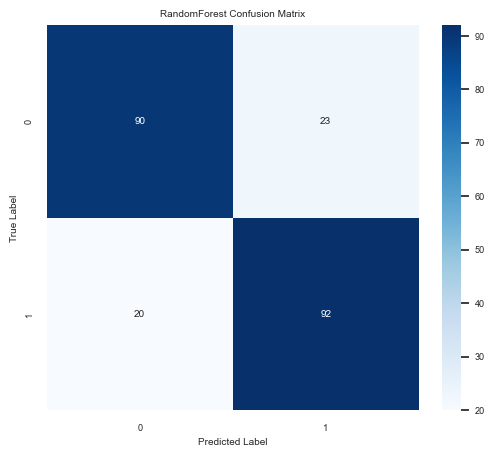

Model: GradientBoost
Accuracy Score: 0.8267
Best Parameters: {'learning_rate': 0.040436634408188066, 'max_depth': 2, 'n_estimators': 501}
              precision    recall  f1-score   support

           1       0.82      0.83      0.83       113
           4       0.83      0.82      0.83       112

    accuracy                           0.83       225
   macro avg       0.83      0.83      0.83       225
weighted avg       0.83      0.83      0.83       225



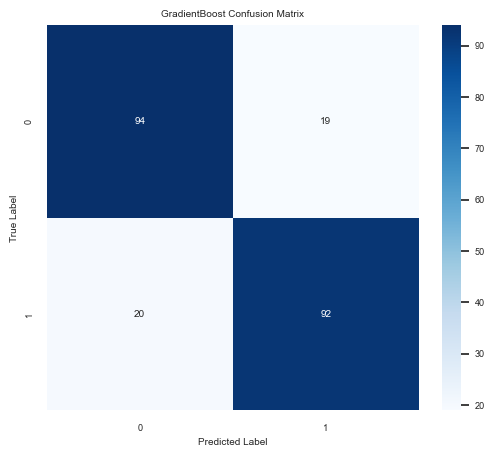

Model: LogisticRegression
Accuracy Score: 0.7911
Best Parameters: {'C': 1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           1       0.79      0.80      0.79       113
           4       0.79      0.79      0.79       112

    accuracy                           0.79       225
   macro avg       0.79      0.79      0.79       225
weighted avg       0.79      0.79      0.79       225



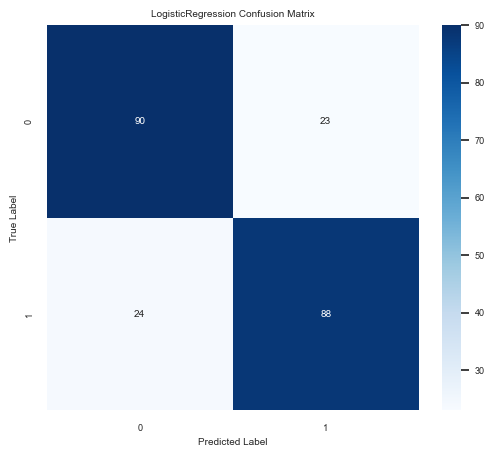

Model: SVM
Accuracy Score: 0.7956
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.79      0.81      0.80       113
           4       0.80      0.79      0.79       112

    accuracy                           0.80       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.80      0.80      0.80       225



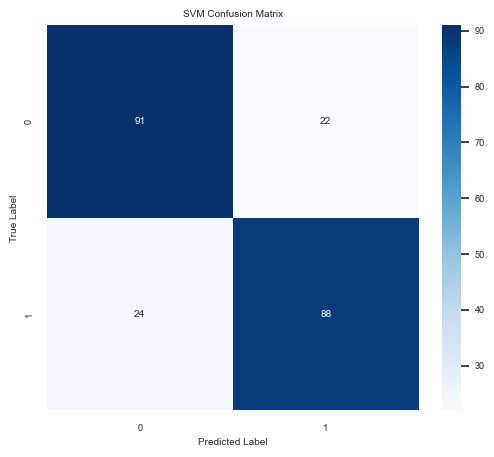

Model: KNN
Accuracy Score: 0.8133
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 29, 'weights': 'distance'}
              precision    recall  f1-score   support

           1       0.83      0.79      0.81       113
           4       0.80      0.84      0.82       112

    accuracy                           0.81       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.81      0.81      0.81       225



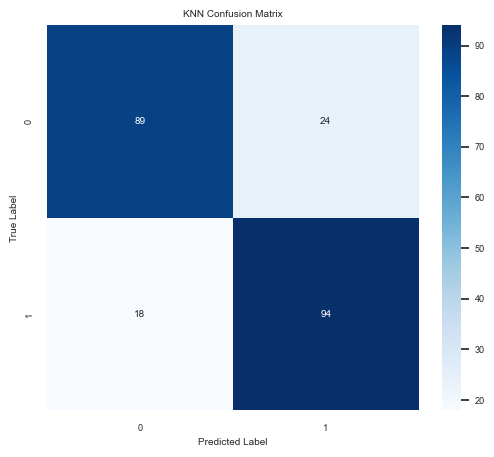

In [74]:
# Run models and print results
for model_name, (model, parameters) in models.items():
    clf = GridSearchCV(model, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    best_models[model_name] = clf.best_estimator_
    
    y_pred = clf.predict(X_test)
    print(f"Model: {model_name}")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
    print("Best Parameters:", clf.best_params_)
    print(classification_report(y_test, y_pred))
    
    print("="*60)

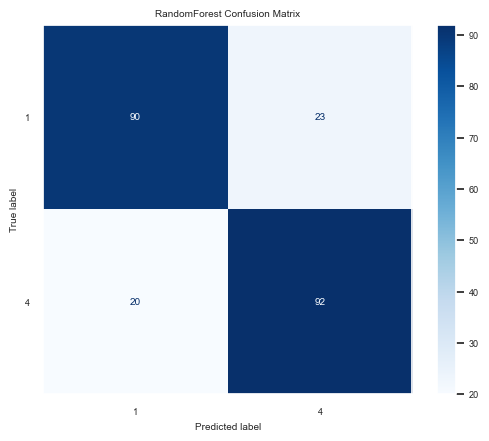

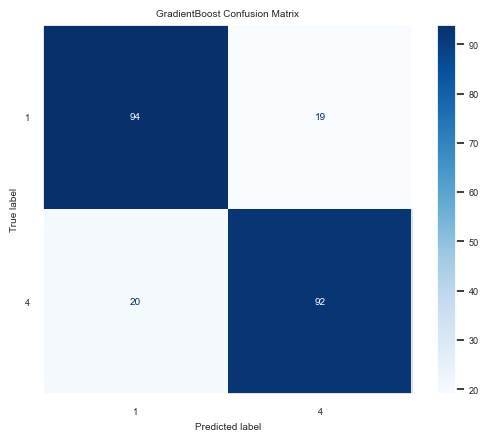

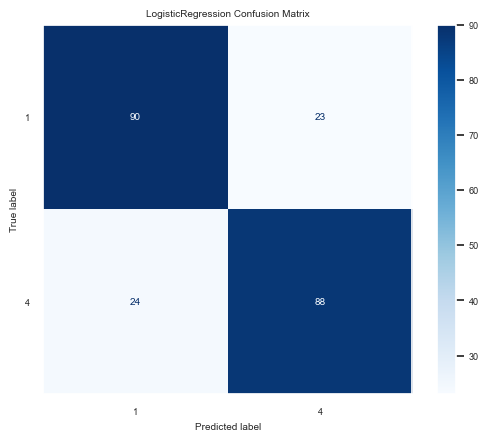

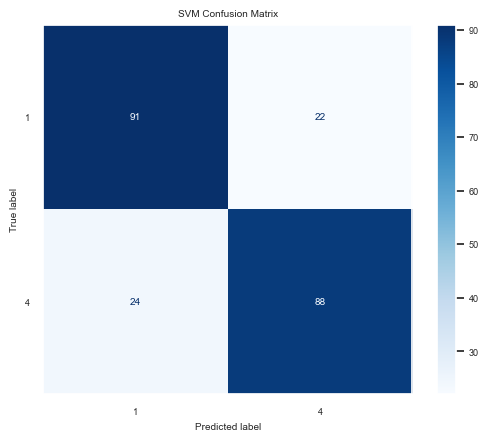

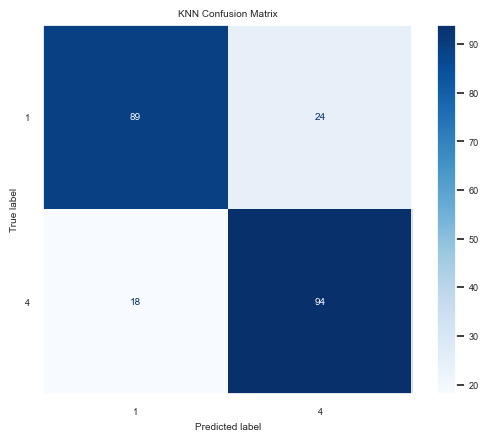

In [104]:
# Plot confusion matrices

for name, estimator in best_models.items():
    disp = ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [106]:
# Rerun GBM gridsearch with more estimators

new_param_grid = {"n_estimators": range(50,1000,50), "max_depth": [2], 'learning_rate': [0.0404]}
gridsearch_attempt = GridSearchCV(GradientBoostingClassifier(),new_param_grid,cv=5)
gridsearch_attempt.fit(X_train,y_train)
gridsearch_y_pred = gridsearch_attempt.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, gridsearch_y_pred):.4f}")
print("Best Parameters:", gridsearch_attempt.best_params_)
print(classification_report(y_test, gridsearch_y_pred))
best_models["GradientBoost_2"] = gridsearch_attempt.best_estimator_

Accuracy Score: 0.8267
Best Parameters: {'learning_rate': 0.0404, 'max_depth': 2, 'n_estimators': 450}
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       113
           4       0.83      0.81      0.82       112

    accuracy                           0.83       225
   macro avg       0.83      0.83      0.83       225
weighted avg       0.83      0.83      0.83       225



In [75]:
# Load and preprocess data - option 2 (Include SPISI score sum as a predictor)

data = pd.read_excel('Combined_data.xlsx',sheet_name="noDASS")
# print(data.head())

data['OCI-R_quartile'] = pd.qcut(data['OCI-R_sum'].rank(method="first"), 4, labels=[1, 2, 3, 4]) # Used pandas 'rank' method to make quartiles actually equally sized

# Remove middle participants; leave only top and bottom quartiles
data_extremes = data[(data["OCI-R_quartile"]==1) | (data["OCI-R_quartile"]==4)]
# data_extremes[["AggregatedID","OCI-R_quartile"]]
features = [col for col in data_extremes.columns if 'SPISI' in col] # features include the scores on SPISI questions + their sum
X = data_extremes[features]
y = data_extremes['OCI-R_quartile']

# Scale data - required by SVM and KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Model: RandomForest
Accuracy Score: 0.7911
Best Parameters: {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 451}
              precision    recall  f1-score   support

           1       0.81      0.76      0.79       113
           4       0.77      0.82      0.80       112

    accuracy                           0.79       225
   macro avg       0.79      0.79      0.79       225
weighted avg       0.79      0.79      0.79       225



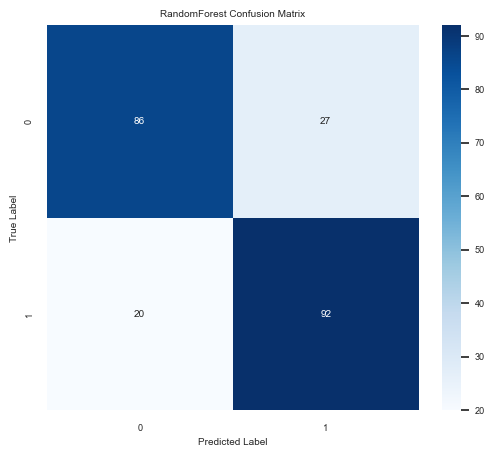

Model: GradientBoost
Accuracy Score: 0.8089
Best Parameters: {'learning_rate': 0.0132237612712501, 'max_depth': 2, 'n_estimators': 401}
              precision    recall  f1-score   support

           1       0.83      0.78      0.80       113
           4       0.79      0.84      0.81       112

    accuracy                           0.81       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.81      0.81      0.81       225



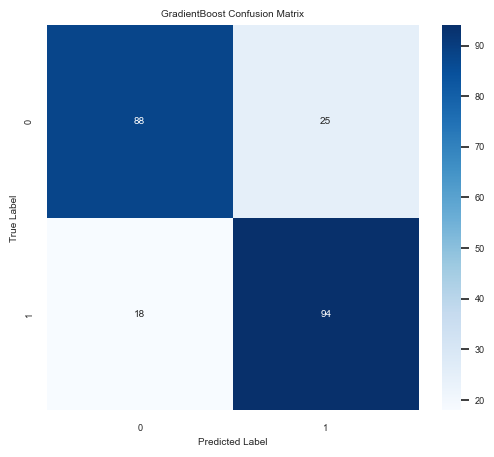

Model: LogisticRegression
Accuracy Score: 0.7911
Best Parameters: {'C': 1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           1       0.79      0.80      0.79       113
           4       0.79      0.79      0.79       112

    accuracy                           0.79       225
   macro avg       0.79      0.79      0.79       225
weighted avg       0.79      0.79      0.79       225



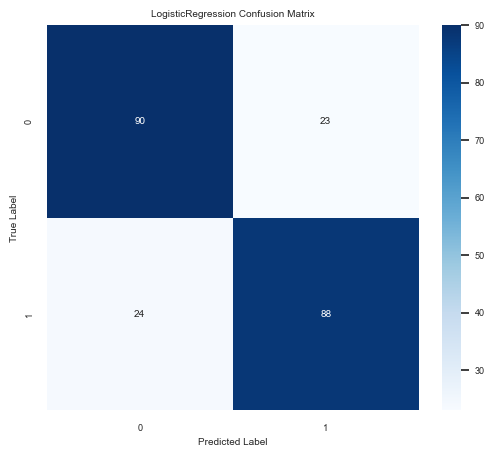

Model: SVM
Accuracy Score: 0.7956
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.79      0.81      0.80       113
           4       0.80      0.79      0.79       112

    accuracy                           0.80       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.80      0.80      0.80       225



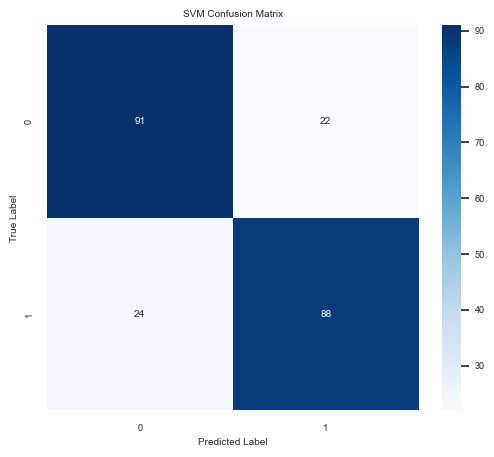

Model: KNN
Accuracy Score: 0.8044
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 23, 'weights': 'uniform'}
              precision    recall  f1-score   support

           1       0.83      0.77      0.80       113
           4       0.78      0.84      0.81       112

    accuracy                           0.80       225
   macro avg       0.81      0.80      0.80       225
weighted avg       0.81      0.80      0.80       225



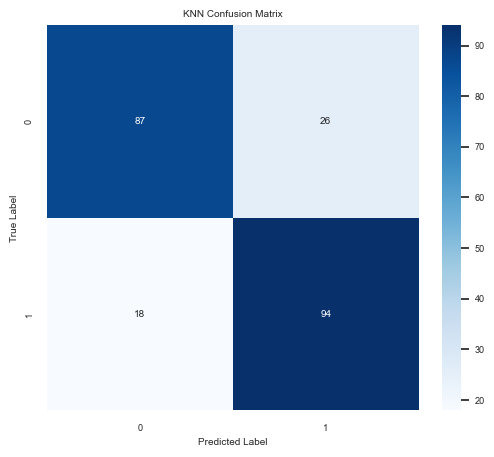

In [76]:
# Run models and print results - this time including SPISI score sum as a predictor
best_models_with_sum = {}

for model_name, (model, parameters) in models.items():
    clf = GridSearchCV(model, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    best_models_with_sum[model_name] = clf.best_estimator_
    
    y_pred = clf.predict(X_test)
    print(f"Model: {model_name}")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
    print("Best Parameters:", clf.best_params_)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, f'{model_name} Confusion Matrix')
    print("="*60)

# Results are not as good as just using items - which is great news.

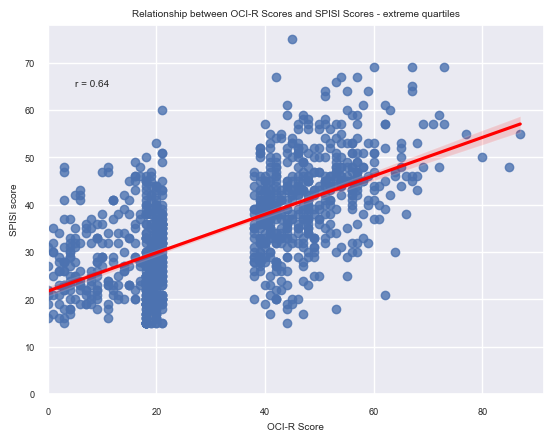

In [93]:
# Print Scatterplots of raw data

# scatter_plotter_with_regline(data["OCI-R_sum"],data["SPISI_sum"],("OCI-R Score","SPISI score"),"Relationship between OCI-R Scores and SPISI Scores",pearson=0.519) # Scatterplot of all results
# scatter_plotter(data,data["OCI-R_sum"],data["SPISI_sum"],("OCI-R Score","SPISI score"),"Relationship between OCI-R Scores and SPISI Scores") # Scatterplot of all results

scatter_plotter_with_regline(data[data["OCI-R_quartile"].isin([1,4])]["OCI-R_sum"],data[data["OCI-R_quartile"].isin([1,4])]["SPISI_sum"],("OCI-R Score","SPISI score"),"Relationship between OCI-R Scores and SPISI Scores - extreme quartiles",pearson=0.635) # Scatterplot of Q1 and Q4
# scatter_plotter(data,data[data["OCI-R_quartile"].isin([1,4])]["OCI-R_sum"],data[data["OCI-R_quartile"].isin([1,4])]["SPISI_sum"],("OCI-R Score","SPISI score"),"Relationship between OCI-R Scores and SPISI Scores - extreme quartiles") # Scatterplot of Q1 and Q4

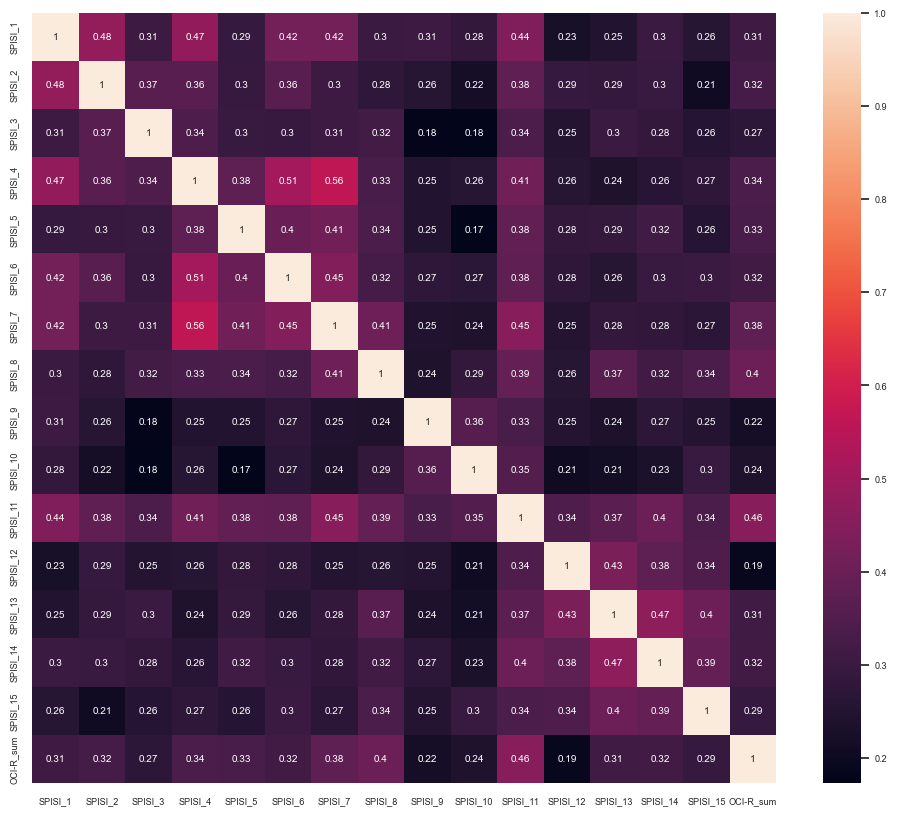

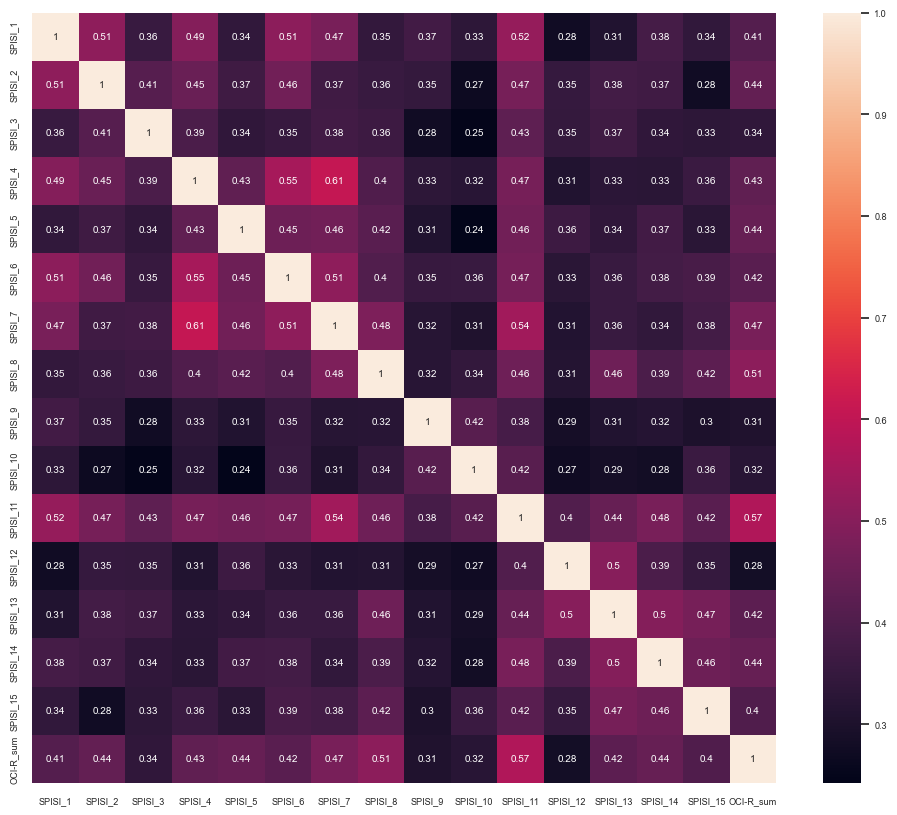

In [125]:
# Correlation heatmap on full dataset - all 4 quartiles
corr_features = features.copy()
corr_features.append('OCI-R_sum')
# print(corr_features)
correlation_matrix = data[corr_features].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale=0.6)
_ = sns.heatmap(correlation_matrix, annot=True)

# Correlation heatmap on extreme quartiles only
corr_features = features.copy()
corr_features.append('OCI-R_sum')
# print(corr_features)
correlation_matrix_extremes = data_extremes[corr_features].corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.set(font_scale=0.6)
_ = sns.heatmap(correlation_matrix_extremes, annot=True)

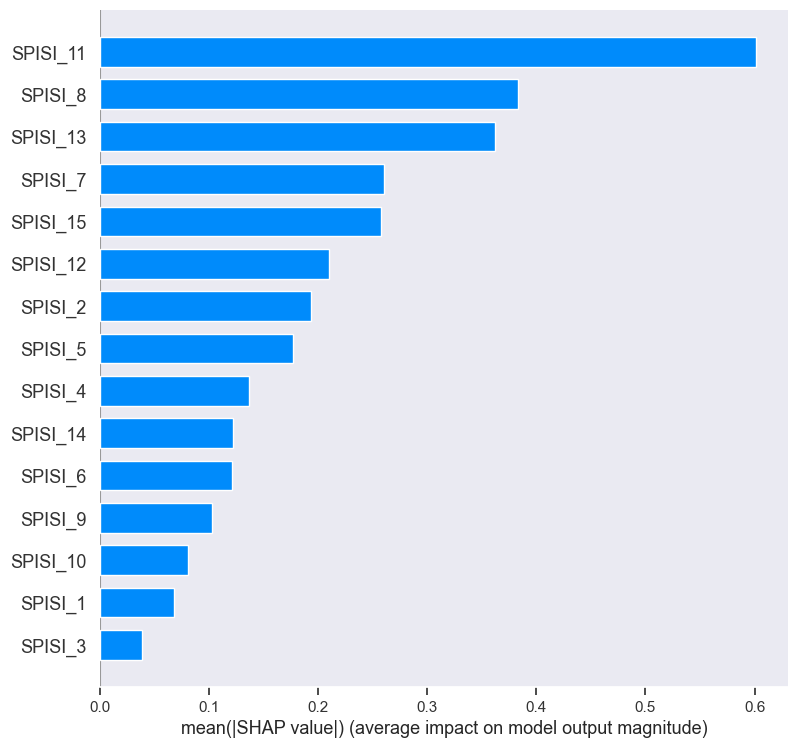

SHAP values for Gradient Boost


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


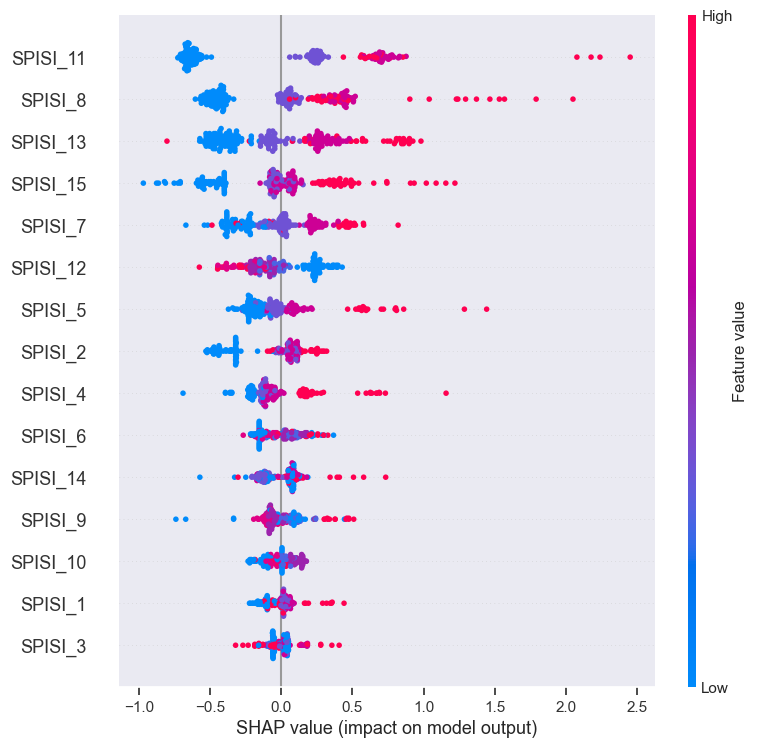

SHAP values for Gradient Boost


In [124]:
# Plot shap values for best model

display_shap_values_bars(best_models["GradientBoost"], X_train, "Gradient Boost")
display_shap_values_point(best_models["GradientBoost"], X_train, "Gradient Boost")